In [26]:
from __future__ import print_function

from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Dropout, GRU, Flatten
from keras import optimizers
import numpy as np
import csv
import os
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [2]:
nteams = 20
nmatches = (nteams-1)*2

Data Pre-processing

In [3]:
def season_team_map(season_dir):
    readme = season_dir + '/README.md'
    f = open(readme, 'r')
    
    s = "  "
    
    # skip to teams
    while(s[1] != '1'):
        s = f.readline()
        if(len(s)<=1):
            s = "  "

    team_map = {}

    for i in range(20):
        team_map[s[4:].split('  ')[0]] = i
        s = f.readline()

    f.close()
    
    return team_map

In [4]:
def season_team_map_div_2(season_dir):
    readme = season_dir + '/README.md'
    f = open(readme, 'r')
    
    s = "  "
    
    # skip to teams
    while(s[1] != '1'):
        s = f.readline()
        if(len(s)<=1):
            s = "  "
            
    s = f.readline()
    if(len(s)<=1):
        s = "  "    
        
     # skip to div 2 teams
    while(s[:3] != ' 1.'):
        s = f.readline()
        if(len(s)<=1):
            s = "  "

    team_map = {}

    for i in range(20):
        team_map[s[4:].split('  ')[0]] = i
        s = f.readline()

    f.close()
    
    return team_map

In [5]:
def season_game_mat(season_dir, team_map, div=1):
    game_mat = np.zeros((nteams, nmatches), dtype=int)
    team_index = np.zeros(nteams, dtype=int)

    csvfile = ''
    
    for entry in os.scandir(season_dir):
        if(div==1):
            if '/1-' in entry.path:
                csvfile = entry.path
        elif(div==2):
            if '/2-' in entry.path:
                csvfile = entry.path
            
    with open(csvfile) as gf:
        reader = csv.reader(gf)
        header = next(reader)
        if(header[0] == 'Round'):
            new_format = 1
        else:
            new_format = 0;
        for row in reader:
            if(new_format):
                team1 = team_map[row[2].split(' (')[0]]
                team2 = team_map[row[5].split(' (')[0]]

                score = row[3].split('-')
            else:
                team1 = team_map[row[1]]
                team2 = team_map[row[2]]

                score = row[3].split('-')
            # 1 for win, 0 for draw, -1 for loss

            game_mat[team1, team_index[team1]] = int(score[0]) - int(score[1])
            game_mat[team2, team_index[team2]] = int(score[1]) - int(score[0])

            team_index[team1] += 1
            team_index[team2] += 1
    
    return np.transpose(game_mat)

In [6]:
country_dirs = []
season_dirs = []

nseasons = 0
team_maps = []
game_mats = []

for entry in os.scandir('./data'):
    if entry.is_dir():
        country_dirs.append(entry.path)

for cdir in country_dirs:
    for entry in os.scandir(cdir):
        if entry.is_dir():
            season_dir = entry.path
            team_maps.append(season_team_map(season_dir))
            game_mats.append(season_game_mat(season_dir, team_maps[nseasons]))
            nseasons += 1
            if(cdir=='./data/fr-france-master' and int(entry.name.split('-')[0])>=2002):
                team_maps.append(season_team_map_div_2(season_dir))
                game_mats.append(season_game_mat(season_dir, team_maps[nseasons], div=2))
                nseasons += 1

In [7]:
def eucl_error(outputs, targets):
    return np.mean(np.abs(targets - outputs))

In [8]:
def ternarize(x):
    if(x > 0.5):
        return 1
    if(x < -0.5):
        return -1
    return 0

def disc_error(outputs, targets):
    ternarize_fn = np.vectorize(ternarize)
    ternarized_outputs = ternarize_fn(np.round(outputs))
    ternarized_targets = ternarize_fn(np.round(targets))
    err = 0
    n = 0
    for i in range(len(outputs)):
        for j in range(len(outputs[i])):
            if(int(ternarized_outputs[i][j]) != int(ternarized_targets[i][j])):
                err += 1
            n += 1
    return float(err)/n

In [9]:
ntraining = int(nseasons*0.7)
ntesting = nseasons - ntraining

training_game_mats = game_mats[:ntraining]
testing_game_mats = game_mats[ntesting:]

X_training = np.reshape(np.array(training_game_mats), (ntraining*nmatches, nteams))
lengths = np.full(ntraining, nmatches)

In [10]:
nseasons

88

In [11]:
ntraining

61

In [12]:
X_trainings = []
Y_trainings = []
for i in range(1, nmatches):
    X_training = []
    Y_training = []
    for game_mat in training_game_mats:
        for j in range(nmatches-i):
            X_training.append(np.ndarray.flatten(game_mat[j:j+i]))
            Y_training.append(game_mat[j+i])
    
    X_training = np.array(X_training).reshape(-1,i,nteams)
    Y_training = np.array(Y_training).reshape(-1,nteams)
    X_trainings.append(X_training)
    Y_trainings.append(Y_training)

In [13]:
X_testings = []
Y_testings = []
for i in range(1, nmatches):
    X_testing = []
    Y_testing = []
    for game_mat in testing_game_mats:
        for j in range(nmatches-i):
            X_testing.append(np.ndarray.flatten(game_mat[j:j+i]))
            Y_testing.append(game_mat[j+i])
            
    X_testing = np.array(X_testing).reshape(-1,i,nteams)
    Y_testing = np.array(Y_testing).reshape(-1,nteams)
    X_testings.append(X_testing)
    Y_testings.append(Y_testing)

In [36]:
layer_sizes = [300]
layers = [1]
min_sequence_length = 1
max_sequence_length = 7
epochs = [130]
batch_sizes = [32]
learning_rates = [0.001]
dropouts = [0.2]
cell_types = ["Attention"]

In [38]:
rnns = {}
for layer_size in layer_sizes:
    for layer_num in layers:
        for epochs_num in epochs:
            for batch_size in batch_sizes:
                for lr in learning_rates:
                    for dropout in dropouts:
                        for ct in cell_types:
                            key = str(layer_size)+"_"+str(layer_num)+"_"+str(epochs_num)+"_"+str(batch_size)+"_"+str(lr)+"_"+str(dropout)+"_"+ct
                            rnns[key] = []

In [39]:
histories = {}
for layer_size in layer_sizes:
    for layer_num in layers:
        for epochs_num in epochs:
            for batch_size in batch_sizes:
                for lr in learning_rates:
                    for dropout in dropouts:
                        for ct in cell_types:
                            key = str(layer_size)+"_"+str(layer_num)+"_"+str(epochs_num)+"_"+str(batch_size)+"_"+str(lr)+"_"+str(dropout)+"_"+ct
                            histories[key] = []

In [40]:
for i in range(min_sequence_length, max_sequence_length+1):
    print("Sequence Length of " + str(i))
    for size in layer_sizes:
        for layer_num in layers:
            for epochs_num in epochs:
                for batch_size in batch_sizes:
                    for lr in learning_rates:
                        for dropout in dropouts:
                            for ct in cell_types:
                                key = str(layer_size)+"_"+str(layer_num)+"_"+str(epochs_num)+"_"+str(batch_size)+"_"+str(lr)+"_"+str(dropout)+"_"+ct
                                print(key)
                                model = Sequential()
                                
                                if(ct=="LSTM"):
                                    if(layer_num==1):
                                        model.add(LSTM(size, input_shape=(i+1, nteams)))
                                        model.add(Dropout(dropout))
                                    else:
                                        model.add(LSTM(int(size/layer_num), input_shape=(i+1, nteams),return_sequences=True))
                                        model.add(Dropout(dropout))
                                        model.add(LSTM(int(size/layer_num)))
                                        model.add(Dropout(dropout))
                                elif(ct=="GRU"):
                                    if(layer_num==1):
                                        model.add(GRU(size, input_shape=(i+1, nteams)))
                                        model.add(Dropout(dropout))
                                    else:
                                        model.add(GRU(int(size/layer_num), input_shape=(i+1, nteams),return_sequences=True))
                                        model.add(Dropout(dropout))
                                        model.add(GRU(int(size/layer_num)))
                                        model.add(Dropout(dropout))
                                elif(ct=="Attention"):
                                    model.add(LSTM(int(size), input_shape=(i+1, nteams),return_sequences=True))
                                    model.add(Dropout(dropout))
                                    model.add(Flatten())
                                
                                model.add(Dense(nteams, activation='tanh'))

                                opt = optimizers.Adam(lr=lr)
                                model.compile(loss='mean_squared_error', optimizer=opt)
                                histories[key].append(model.fit(X_trainings[i], np.array(Y_trainings[i]), batch_size=batch_size, epochs=epochs_num))
                                rnns[key].append(model)

Sequence Length of 1
300_1_130_32_0.001_0.2_Attention
Epoch 1/130
2196/2196 [==============================] - 2s 819us/step - loss: 2.7001
Epoch 2/130
2196/2196 [==============================] - 1s 503us/step - loss: 2.6240
Epoch 3/130
2196/2196 [==============================] - 1s 520us/step - loss: 2.5996
Epoch 4/130
2196/2196 [==============================] - 1s 616us/step - loss: 2.5826
Epoch 5/130
2196/2196 [==============================] - 1s 544us/step - loss: 2.5651
Epoch 6/130
2196/2196 [==============================] - 2s 698us/step - loss: 2.5470 0
Epoch 7/130
2196/2196 [==============================] - ETA: 0s - loss: 2.527 - 1s 606us/step - loss: 2.5245
Epoch 8/130
2196/2196 [==============================] - 2s 713us/step - loss: 2.4999 0s - loss
Epoch 9/130
2196/2196 [==============================] - 2s 841us/step - loss: 2.4664
Epoch 10/130
2196/2196 [==============================] - 1s 508us/step - loss: 2.4252
Epoch 11/130
2196/2196 [=========================

2196/2196 [==============================] - 1s 486us/step - loss: 1.2628
Epoch 94/130
2196/2196 [==============================] - 1s 511us/step - loss: 1.2568
Epoch 95/130
2196/2196 [==============================] - 1s 601us/step - loss: 1.2580
Epoch 96/130
2196/2196 [==============================] - 2s 685us/step - loss: 1.2566
Epoch 97/130
2196/2196 [==============================] - 1s 659us/step - loss: 1.2567
Epoch 98/130
2196/2196 [==============================] - 2s 740us/step - loss: 1.2541
Epoch 99/130
2196/2196 [==============================] - 2s 719us/step - loss: 1.2531
Epoch 100/130
2196/2196 [==============================] - 1s 524us/step - loss: 1.2514
Epoch 101/130
2196/2196 [==============================] - 1s 632us/step - loss: 1.2511
Epoch 102/130
2196/2196 [==============================] - 2s 726us/step - loss: 1.2489
Epoch 103/130
2196/2196 [==============================] - 1s 678us/step - loss: 1.2500
Epoch 104/130
2196/2196 [===========================

2135/2135 [==============================] - 1s 574us/step - loss: 1.2581
Epoch 57/130
2135/2135 [==============================] - 1s 556us/step - loss: 1.2565
Epoch 58/130
2135/2135 [==============================] - 1s 540us/step - loss: 1.2539
Epoch 59/130
2135/2135 [==============================] - 1s 544us/step - loss: 1.2517
Epoch 60/130
2135/2135 [==============================] - 1s 526us/step - loss: 1.2523
Epoch 61/130
2135/2135 [==============================] - 1s 488us/step - loss: 1.2492
Epoch 62/130
2135/2135 [==============================] - 1s 494us/step - loss: 1.2466
Epoch 63/130
2135/2135 [==============================] - 1s 492us/step - loss: 1.2441
Epoch 64/130
2135/2135 [==============================] - 1s 497us/step - loss: 1.2443
Epoch 65/130
2135/2135 [==============================] - 1s 588us/step - loss: 1.2442
Epoch 66/130
2135/2135 [==============================] - 1s 553us/step - loss: 1.2409
Epoch 67/130
2135/2135 [==============================] 

2074/2074 [==============================] - 1s 588us/step - loss: 1.5962
Epoch 20/130
2074/2074 [==============================] - 1s 582us/step - loss: 1.5566
Epoch 21/130
2074/2074 [==============================] - 1s 571us/step - loss: 1.5211
Epoch 22/130
2074/2074 [==============================] - 1s 581us/step - loss: 1.4856
Epoch 23/130
2074/2074 [==============================] - 1s 589us/step - loss: 1.4625
Epoch 24/130
2074/2074 [==============================] - 1s 589us/step - loss: 1.4349
Epoch 25/130
2074/2074 [==============================] - 1s 627us/step - loss: 1.4149
Epoch 26/130
2074/2074 [==============================] - 1s 585us/step - loss: 1.3968
Epoch 27/130
2074/2074 [==============================] - 1s 588us/step - loss: 1.3794
Epoch 28/130
2074/2074 [==============================] - 1s 599us/step - loss: 1.3685
Epoch 29/130
2074/2074 [==============================] - 1s 586us/step - loss: 1.3552
Epoch 30/130
2074/2074 [==============================] 

2074/2074 [==============================] - 1s 607us/step - loss: 1.1894
Epoch 113/130
2074/2074 [==============================] - 1s 628us/step - loss: 1.1879
Epoch 114/130
2074/2074 [==============================] - 1s 624us/step - loss: 1.1876
Epoch 115/130
2074/2074 [==============================] - 1s 684us/step - loss: 1.1874
Epoch 116/130
2074/2074 [==============================] - 1s 625us/step - loss: 1.1867
Epoch 117/130
2074/2074 [==============================] - 1s 609us/step - loss: 1.1866
Epoch 118/130
2074/2074 [==============================] - 1s 612us/step - loss: 1.1868
Epoch 119/130
2074/2074 [==============================] - 1s 615us/step - loss: 1.1867
Epoch 120/130
2074/2074 [==============================] - 1s 612us/step - loss: 1.1858
Epoch 121/130
2074/2074 [==============================] - 1s 675us/step - loss: 1.1849
Epoch 122/130
2074/2074 [==============================] - 1s 634us/step - loss: 1.1851
Epoch 123/130
2074/2074 [=====================

2013/2013 [==============================] - 1s 639us/step - loss: 1.2123
Epoch 75/130
2013/2013 [==============================] - 1s 631us/step - loss: 1.2110
Epoch 76/130
2013/2013 [==============================] - 1s 637us/step - loss: 1.2109
Epoch 77/130
2013/2013 [==============================] - 1s 635us/step - loss: 1.2101
Epoch 78/130
2013/2013 [==============================] - 1s 638us/step - loss: 1.2098
Epoch 79/130
2013/2013 [==============================] - 1s 643us/step - loss: 1.2080
Epoch 80/130
2013/2013 [==============================] - 1s 648us/step - loss: 1.2066
Epoch 81/130
2013/2013 [==============================] - 1s 698us/step - loss: 1.2064
Epoch 82/130
2013/2013 [==============================] - 1s 726us/step - loss: 1.2064
Epoch 83/130
2013/2013 [==============================] - 1s 628us/step - loss: 1.2068
Epoch 84/130
2013/2013 [==============================] - 1s 630us/step - loss: 1.2061
Epoch 85/130
2013/2013 [==============================] 

Epoch 37/130
1952/1952 [==============================] - 1s 721us/step - loss: 1.2694
Epoch 38/130
1952/1952 [==============================] - 1s 722us/step - loss: 1.2675
Epoch 39/130
1952/1952 [==============================] - 1s 763us/step - loss: 1.2635
Epoch 40/130
1952/1952 [==============================] - 1s 699us/step - loss: 1.2594 0s - loss
Epoch 41/130
1952/1952 [==============================] - 1s 713us/step - loss: 1.2568
Epoch 42/130
1952/1952 [==============================] - 1s 731us/step - loss: 1.2561
Epoch 43/130
1952/1952 [==============================] - 2s 807us/step - loss: 1.2536
Epoch 44/130
1952/1952 [==============================] - 1s 707us/step - loss: 1.2509
Epoch 45/130
1952/1952 [==============================] - 1s 708us/step - loss: 1.2497 0s - los
Epoch 46/130
1952/1952 [==============================] - 1s 765us/step - loss: 1.2471
Epoch 47/130
1952/1952 [==============================] - 1s 724us/step - loss: 1.2474
Epoch 48/130
1952/1952 [

1952/1952 [==============================] - 1s 689us/step - loss: 1.1850
Sequence Length of 6
300_1_130_32_0.001_0.2_Attention
Epoch 1/130
1891/1891 [==============================] - 3s 1ms/step - loss: 2.6888
Epoch 2/130
1891/1891 [==============================] - 1s 755us/step - loss: 2.6101
Epoch 3/130
1891/1891 [==============================] - 1s 765us/step - loss: 2.5732
Epoch 4/130
1891/1891 [==============================] - 2s 810us/step - loss: 2.5347
Epoch 5/130
1891/1891 [==============================] - 1s 765us/step - loss: 2.4981
Epoch 6/130
1891/1891 [==============================] - 1s 778us/step - loss: 2.4513
Epoch 7/130
1891/1891 [==============================] - 1s 789us/step - loss: 2.3899
Epoch 8/130
1891/1891 [==============================] - 2s 870us/step - loss: 2.3125
Epoch 9/130
1891/1891 [==============================] - 2s 805us/step - loss: 2.2153
Epoch 10/130
1891/1891 [==============================] - 2s 878us/step - loss: 2.1143
Epoch 11/130


1891/1891 [==============================] - 2s 851us/step - loss: 1.2114
Epoch 94/130
1891/1891 [==============================] - 2s 824us/step - loss: 1.2105
Epoch 95/130
1891/1891 [==============================] - 2s 802us/step - loss: 1.2101
Epoch 96/130
1891/1891 [==============================] - 1s 791us/step - loss: 1.2096
Epoch 97/130
1891/1891 [==============================] - 1s 780us/step - loss: 1.2106
Epoch 98/130
1891/1891 [==============================] - 2s 796us/step - loss: 1.2080
Epoch 99/130
1891/1891 [==============================] - 2s 804us/step - loss: 1.2088
Epoch 100/130
1891/1891 [==============================] - 2s 851us/step - loss: 1.2084
Epoch 101/130
1891/1891 [==============================] - 2s 817us/step - loss: 1.2109
Epoch 102/130
1891/1891 [==============================] - 1s 785us/step - loss: 1.2074
Epoch 103/130
1891/1891 [==============================] - 2s 907us/step - loss: 1.2065
Epoch 104/130
1891/1891 [===========================

1830/1830 [==============================] - 2s 864us/step - loss: 1.2357
Epoch 57/130
1830/1830 [==============================] - 2s 856us/step - loss: 1.2354
Epoch 58/130
1830/1830 [==============================] - 2s 851us/step - loss: 1.2321
Epoch 59/130
1830/1830 [==============================] - 2s 1ms/step - loss: 1.2321A: 0s - loss: 1.21
Epoch 60/130
1830/1830 [==============================] - 3s 1ms/step - loss: 1.2310
Epoch 61/130
1830/1830 [==============================] - 3s 1ms/step - loss: 1.2292
Epoch 62/130
1830/1830 [==============================] - 2s 1ms/step - loss: 1.2283
Epoch 63/130
1830/1830 [==============================] - 2s 1ms/step - loss: 1.2272
Epoch 64/130
1830/1830 [==============================] - 2s 1ms/step - loss: 1.2286
Epoch 65/130
1830/1830 [==============================] - 2s 1ms/step - loss: 1.2256
Epoch 66/130
1830/1830 [==============================] - 2s 1ms/step - loss: 1.2244
Epoch 67/130
1830/1830 [==============================

In [41]:
rnns

{'300_1_130_32_0.001_0.2_Attention': [<keras.models.Sequential at 0x1a33d6df60>,
  <keras.models.Sequential at 0x1a415f5f60>]}

In [42]:
def score(key):
    training_accs = []
    training_errs = []

    with open('rnn_nt_training_scores_' + key + '.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['Games before prediction', 'Accuracy', 'Euclidean Error'])
        print("training")
        for i in range(min_sequence_length, max_sequence_length+1):
            print(i)
            outputs = rnns[key][i-min_sequence_length].predict(X_trainings[i])
            acc = 1 - disc_error(outputs, np.array(Y_trainings[i]))
            eerr = eucl_error(outputs, np.array(Y_trainings[i]))

            writer.writerow([i, acc, eerr])
            training_accs.append(acc)
            training_errs.append(eerr)
            
    testing_accs = []
    testing_errs = []

    with open('rnn_nt_testing_scores_' + key + '.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['Games before prediction', 'Accuracy', 'Euclidean Error'])
        print("testing")
        for i in range(min_sequence_length, max_sequence_length+1):
            print(i)
            outputs = rnns[key][i-min_sequence_length].predict(X_testings[i])
            acc = 1 - disc_error(outputs, np.array(Y_testings[i]))
            eerr = eucl_error(outputs, np.array(Y_testings[i]))

            writer.writerow([i, acc, eerr])
            testing_accs.append(acc)
            testing_errs.append(eerr)
    
    training_accs_dict[key] = training_accs
    training_errs_dict[key] = training_errs
    testing_accs_dict[key] = testing_accs
    testing_errs_dict[key] = testing_errs

In [43]:
training_accs_dict = {}
training_errs_dict = {}
testing_accs_dict = {}
testing_errs_dict = {}

In [44]:
for layer_size in layer_sizes:
    for layer_num in layers:
        for epochs_num in epochs:
            for batch_size in batch_sizes:
                for lr in learning_rates:
                    for dropout in dropouts:
                        for ct in cell_types:
                            key = str(layer_size)+"_"+str(layer_num)+"_"+str(epochs_num)+"_"+str(batch_size)+"_"+str(lr)+"_"+str(dropout)+"_"+ct
                            print(key)
                            score(key)

300_1_130_32_0.001_0.2_Attention
training
1
2
3
4
5
6
7
testing
1
2
3
4
5
6
7


In [45]:
def plot(y, ylabel, title, imname, ylim):
    x = range(min_sequence_length, max_sequence_length+1)
#     yfit = np.poly1d(np.polyfit(x, y, 1))(np.unique(x))
#     r2 = np.round(r2_score(y, yfit),decimals=2)
    maxi = np.round(np.max(y), decimals=2)
    

    plt.scatter(x, y, s = 5)
    plt.axis([0,max_sequence_length+1,0,ylim])
    plt.text(1, 0.85, 'Max: ' + str(maxi))
    plt.xlabel('Games before prediction')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.savefig('rnnntplots/' + imname + '.png')
    plt.show()

In [46]:
def plot_loss_curve(y, xlim, title, imname):
    x = range(1,xlim+1)
    plt.axis([1,xlim+1,0,3])
    plt.plot(x, y)
    plt.xlabel('Epochs')
    plt.ylabel('Training Loss')
    plt.title(title)
    plt.savefig('rnnnt_losscurves/' + imname + '.png')
    plt.show()

300_1_130_32_0.001_0.2_Attention


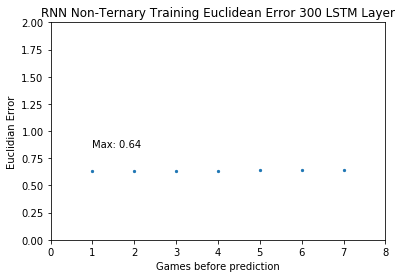

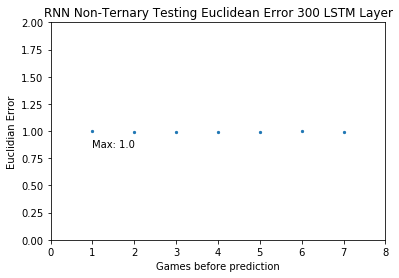

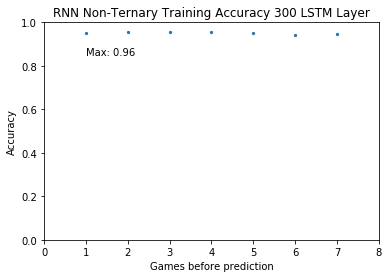

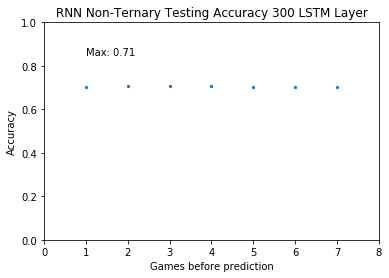

In [47]:
for layer_size in layer_sizes:
    for layer_num in layers:
        for epochs_num in epochs:
            for batch_size in batch_sizes:
                for lr in learning_rates:
                    for dropout in dropouts:
                        for ct in cell_types:
                            key = str(layer_size)+"_"+str(layer_num)+"_"+str(epochs_num)+"_"+str(batch_size)+"_"+str(lr)+"_"+str(dropout)+"_"+ct
                            print(key)                         
                            title = ' ' + str(size) + ' LSTM Layer'
                            plot(training_errs_dict[key], 'Euclidian Error', 'RNN Non-Ternary Training Euclidean Error' + title, 'rnn_nt_training_error_plot_'+key, 2)
                            plot(testing_errs_dict[key], 'Euclidian Error', 'RNN Non-Ternary Testing Euclidean Error' + title, 'rnn_nt_testing_error_plot_'+key, 2)
                            plot(training_accs_dict[key], 'Accuracy', 'RNN Non-Ternary Training Accuracy' + title, 'rnn_nt_training_accuracy_plot_'+key, 1)
                            plot(testing_accs_dict[key], 'Accuracy', 'RNN Non-Ternary Testing Accuracy' + title, 'rnn_nt_testing_accuracy_plot_'+key, 1)

300_1_130_32_0.001_0.2_Attention


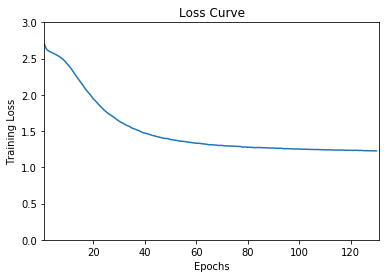

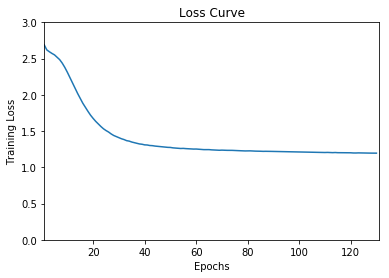

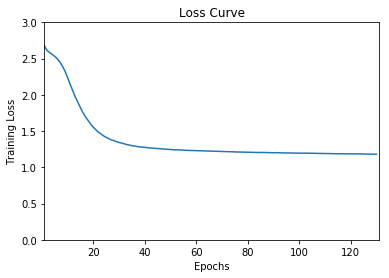

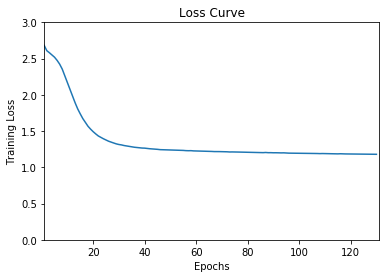

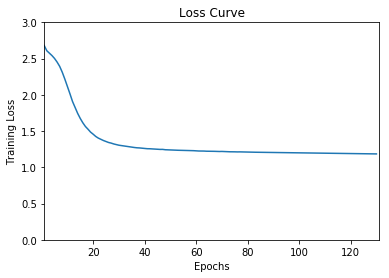

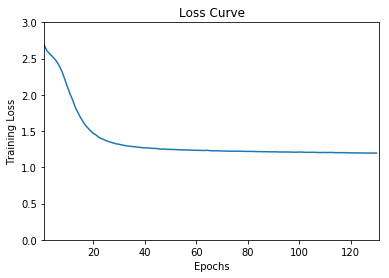

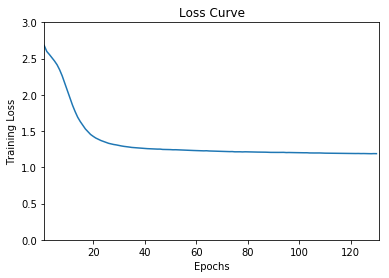

In [48]:
for layer_size in layer_sizes:
    for layer_num in layers:
        for epochs_num in epochs:
            for batch_size in batch_sizes:
                for lr in learning_rates:
                    for dropout in dropouts:
                        for ct in cell_types:
                            key = str(layer_size)+"_"+str(layer_num)+"_"+str(epochs_num)+"_"+str(batch_size)+"_"+str(lr)+"_"+str(dropout)+"_"+ct
                            print(key)  
                            for i in range(max_sequence_length-min_sequence_length+1):
                                plot_loss_curve(histories[key][i].history['loss'], epochs_num, "Loss Curve", key+"_"+str(i))

In [49]:
for layer_size in layer_sizes:
    for layer_num in layers:
        for epochs_num in epochs:
            for batch_size in batch_sizes:
                for lr in learning_rates:
                    for dropout in dropouts:
                        for ct in cell_types:
                            key = str(layer_size)+"_"+str(layer_num)+"_"+str(epochs_num)+"_"+str(batch_size)+"_"+str(lr)+"_"+str(dropout)+"_"+ct
                            print(key) 
                            with open('rnn_nt_loss_curve_' + key + '.csv', 'w') as f:
                                writer = csv.writer(f)
                                listrange = list(range(min_sequence_length,max_sequence_length+1))
                                header = [str(i) for i in listrange]
                                header.insert(0,'Epochs')
                                writer.writerow(header)
                                for i in range(epochs_num):
                                    row = [i+1]
                                    for j in range(max_sequence_length - min_sequence_length + 1):
                                        row.append(histories[key][j].history['loss'][i])
                                    writer.writerow(row)

300_1_130_32_0.001_0.2_Attention
